# Optimal Optimizer
Comparing SGD vs Adam Optimizer

### Model
- model = LSTM
- batch_size = 32
- epochs = 100
- loss = mse


### Data
- time frame: 6 months | 6 months
- features: all of them (110)
- target: EDSS_6...EDSS_222
- imputation 
    - target: interpolation (trailing ends for extrapolation)
    - features: zero-imputation
- time steps: exhaustive (37)

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn as sk
from matplotlib import pyplot as plt

import keras.layers as L
import keras.models as M

/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

def stretch_input(Xtr, n_inputs, time_steps, pot):

    """Xtr_fill is empty 3D numpy array where we extend length of patient observation times t
    pot stands for Patient Observation Time. We only need to do this for our X input"""
    
    Xtr_fill = np.zeros(shape=[Xtr.shape[0],time_steps,n_inputs*pot] , dtype = object) 

    for subject in range(Xtr.shape[0]):
    
        for i in range(time_steps):

            temp = np.concatenate([Xtr[subject][i],Xtr[subject][i+1]]) # changed for pot = 3
            Xtr_fill[subject][i] = temp
            
    return Xtr_fill

def stack_times(data, name, n):
    
    
    """takes in dataframe, column name and n of time steps
    and puts it in long format"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    stacked = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    stacked.append(rest)
    
    return stacked

def stack_dummy(data, name, n):
    
    
    """takes in dataframe and column name
    return that same feature split into dummy columns
    across n time steps (adjacent)"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    f = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    pre_dummy = pd.get_dummies(f.append(rest))
    
    after_dummy = time_dummy(pre_dummy, n)
    
    dummy_value_names = generate_col_names(after_dummy, name)
    time_stepped_dummy_names = time_step_dummy_value_names(dummy_value_names, n)
    
    for t in range(len(after_dummy)):
        
        after_dummy[t].columns = list(time_stepped_dummy_names[t])
        
    #untimed_names_to_order = column_names_per_time_step(col_names_together, "what are you", name[0])
    #names_to_order = select_columns(untimed_names_to_order, n-1)

    return pd.concat(after_dummy, axis = 1, sort = False), dummy_value_names


def time_dummy(dummy_df, n):
    
    """Separates long data frame into time steps 
    (508 subjects (rows) per time step)"""
    
    l = []
    for i in range(n):
        l.append(dummy_df.iloc[i*508:(i+1)*508,:].copy())
    
    return l

def generate_col_names(after_dummy, name):
    
    """Generates column names for result of pd.get_dummies on a feature
    i.e. if A has values x and y, it will generate A_x, A_y"""
    
    return [(str(name[0]) + "_" + str(list(after_dummy[0].columns)[i])) for i in range(len(list(after_dummy[0].columns)))]

def time_step_dummy_value_names(names, n_months):
    
    long_list = [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6) for name in names]
    return np.array(long_list).reshape(-1, len(names))

def add_columns(add_to, name, names_per_t, n):
    
    n = n + 1
    to_add, bare_names = stack_dummy(df, name, n)
    to_remove = select_columns(name, n-1)
    
    """add new dummied features to dataframes (copy)
    and remove undummied version of features
    name is a list
    
    encompasses stack_dummy"""
    
    newdf = add_to.copy()
    column_names = list(to_add.columns)
    
    for i in range(len(column_names)):
        newdf[column_names[i]] = to_add.iloc[:,i]
    newdf.drop(to_remove,axis = 1, inplace = True)
    
    #print(bare_names, name[0])
    
    names_per_t_updated = column_names_per_time_step(names_per_t, bare_names, name[0])
    namesOrder= select_columns(names_per_t_updated, n-1)
    return newdf[namesOrder].copy(), names_per_t_updated

#    return names_per_t_updated
#     print(name[0])
    
    
    return newdf[namesOrder].copy(), names_per_t_updated


def column_names_per_time_step(original_list, add, remove):
    """makes sure EDSS stays at the end
    remove pre """
    
    new_list = original_list.copy()
    
    
    new_list.remove(remove)
    new_list.extend(add)
    
    # makes sure EDSS is always last
    
    new_list.remove('EDSS')
    new_list.append('EDSS')
    
    return new_list

def manual_dummy(df, names, name_list, n):
    
    dfUpdated =df.copy()
    names = [[name] for name in names] # turn to list foramt so that it works
    
    for name in names:
        
        dfUpdated, name_list = add_columns(dfUpdated, name , name_list, n)
   
    return dfUpdated # should I return name_list as well?


# IMPORT DATA & DEFINE N OF TIME STEPS

In [3]:
X = pd.read_csv("../data/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("../data/y_6_months|6_months_exhaustive.csv", index_col = 0)

predictive_features = pd.read_csv("../data/predictive_features_list.csv", index_col = 0, header = None)
predictive_features_list = predictive_features[1].values.tolist()

n_time_steps = len(y.columns)
n_inputs_pure = X.columns.tolist().index("EDSS_0")+1

pot = 1
print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")
print("There will be", n_inputs_pure, "per time step")

The RNN window will slide 37 times
The input length of the training data will be 1 time slices, separated by 6 month intervals
There will be 110 per time step


# Split into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# X train n_time_steps will be +1 to account for stretching
# which will turn 11 time slices of 1 to 10 time slices of 2
X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) # extra time step for stretch
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X reshaped is (355, 37, 110)
y reshaped is (355, 37, 1)
X reshaped is (153, 37, 110)
y reshaped is (153, 37, 1)
(355, 37, 110) (355, 37, 1) (153, 37, 110) (153, 37, 1)


# Set values for the neuron

In [6]:
n_inputs = n_inputs_pure * pot

n_units = 15

n_output = 1

learning_rate = 0.01

print(n_inputs, "inputs per time step (",n_time_steps,") comprising", pot, "time slice,", n_inputs_pure, "features each")

110 inputs per time step ( 37 ) comprising 1 time slice, 110 features each


### Adam Optimizer

In [7]:
model_adam = M.Sequential()

# Each input data point has 20 timesteps, each with 26 features.
# So the input shape (excluding batch_size) is (20, 26), which
# matches the shape of each data point in data_x above.
model_adam.add(L.LSTM(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_adam.add(L.Dense(n_output, activation='linear'))

# You need to pick appropriate loss/optimizers for your problem.
# I'm just using these to make the example compile.
model_adam.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_adam = model_adam.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 8ms/step - loss: 5.1878 - val_loss: 5.3224
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 3.3150 - val_loss: 4.4308
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 2.6347 - val_loss: 3.7467
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 1.9253 - val_loss: 2.6690
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 1.2012 - val_loss: 1.8441
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.8305 - val_loss: 1.3664
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6428 - val_loss: 1.1701
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5550 - val_loss: 1.0726
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5045 - val_loss: 1.0037
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2061 - val_loss: 0.3488
Epoch 82/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2061 - val_loss: 0.3384
Epoch 83/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2045 - val_loss: 0.3453
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2020 - val_loss: 0.3465
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2050 - val_loss: 0.3445
Epoch 86/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2054 - val_loss: 0.3456
Epoch 87/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2073 - val_loss: 0.3437
Epoch 88/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1991 - val_loss: 0.3411
Epoch 89/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1971 - val_loss: 0.3421
Epoch 90/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1967

### SGD Optimizer 

In [8]:
model_sgd = M.Sequential()


model_sgd.add(L.LSTM(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_sgd.add(L.Dense(n_output, activation='linear'))

model_sgd.compile(optimizer = 'sgd', loss = 'mean_squared_error')

history_sgd = model_sgd.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 7ms/step - loss: 3.2053 - val_loss: 5.0773
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.9604 - val_loss: 1.9688
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 0.9012 - val_loss: 1.2591
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6569 - val_loss: 0.9905
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5615 - val_loss: 1.2034
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5832 - val_loss: 0.9234
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5199 - val_loss: 1.2063
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5956 - val_loss: 0.7713
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4442 - val_loss: 0.8339
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2705 - val_loss: 0.3577
Epoch 82/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2683 - val_loss: 0.3580
Epoch 83/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2683 - val_loss: 0.3579
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2677 - val_loss: 0.3548
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2694 - val_loss: 0.3623
Epoch 86/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2678 - val_loss: 0.3602
Epoch 87/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2680 - val_loss: 0.3519
Epoch 88/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2662 - val_loss: 0.3527
Epoch 89/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2658 - val_loss: 0.3547
Epoch 90/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2657

In [9]:
mse_test_sgd = history_sgd.__dict__['history']['val_loss']
mse_train_sgd = history_sgd.__dict__['history']['loss']
sgd_params = history_sgd.__dict__['params']

mse_test_adam = history_adam.__dict__['history']['val_loss']
mse_train_adam = history_adam.__dict__['history']['loss']
adam_params = history_adam.__dict__['params']

### Train 

Best Train Scores
SGD 0.26153172808633723
SGD epoch: 98
Adam 0.18620200333460957
Adam epoch: 99


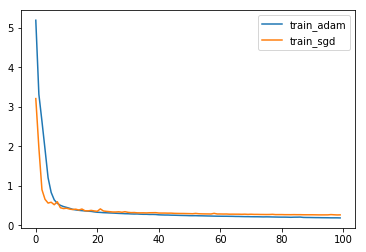

In [10]:
plt.plot(mse_train_adam)
plt.plot(mse_train_sgd)

plt.legend(['train_adam','train_sgd'])

print("Best Train Scores")
print("SGD", np.min(mse_train_sgd))
print("SGD epoch:",np.argmin(mse_train_sgd))

print("Adam", np.min(mse_train_adam))
print("Adam epoch:",np.argmin(mse_train_adam))

# Test

Best Test Scores
SGD 0.3448968284270343
SGD epoch: 91
Adam 0.338403881570093
Adam epoch: 81


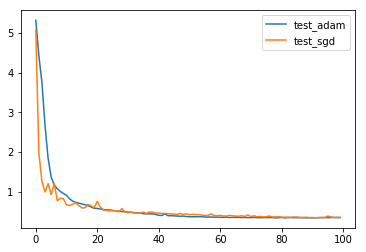

In [11]:
plt.plot(mse_test_adam)
plt.plot(mse_test_sgd)

plt.legend(['test_adam','test_sgd'])

print("Best Test Scores")
print("SGD", np.min(mse_test_sgd))
print("SGD epoch:", np.argmin(mse_test_sgd))

print("Adam", np.min(mse_test_adam))
print("Adam epoch:", np.argmin(mse_test_adam))

In [12]:
LSTM_df = pd.concat([pd.DataFrame(mse_test_adam, columns=['Adam Test MSE']),
pd.DataFrame(mse_test_sgd, columns=['SGD Test MSE']),
pd.DataFrame(mse_train_adam, columns=['Adam Train MSE']),
pd.DataFrame(mse_train_sgd, columns=['SGD Train MSE'])], axis = 1)

In [13]:
LSTM_df.to_csv('LSTM_df_parametrization.csv')